In [1]:
!pip install -qq adapters datasets
!pip install adapters

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive/')


trainx=[]
dev=[]
import json
with open('/content/drive/MyDrive/Deep/train.jsonl', 'r') as f:
            for line in f:
                item = json.loads(line)
                trainx.append((item['text'], item['label']))

with open('/content/drive/MyDrive/Deep/dev.jsonl', 'r') as f:
            for line in f:
                item = json.loads(line)
                dev.append((item['text'], item['label']))

Mounted at /content/drive/


In [3]:

train1=[]
train2=[]
train3=[]
train4=[]
train5=[]
train6=[]

with open('/content/drive/MyDrive/Deep/train.jsonl', 'r') as f:
            for line in f:
                item = json.loads(line)
                if item['label']==0:
                  train1.append((item['text'], item['label']))
                if item['label']==1:
                  train2.append((item['text'], item['label']))
                if item['label']==2:
                  train3.append((item['text'], item['label']))
                if item['label']==3:
                  train4.append((item['text'], item['label']))
                if item['label']==4:
                  train5.append((item['text'], item['label']))
                if item['label']==5:
                  train6.append((item['text'], item['label']))

In [4]:
import json
from torch.utils.data import Dataset
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertModel
import json
import random
class TextClassificationDataset(Dataset):
    def __init__(self, data, tokenizer, max_len):
        self.data = data
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text, label = self.data[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }



from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [22]:
# add adapters to BERT for classification task
from adapters import AutoAdapterModel
# load pre-trained BERT model
bert_model = AutoAdapterModel.from_pretrained("bert-base-uncased")
# By default, this model doesn’t have any heads yet. We add a new one in the next step
bert_model.add_classification_head("my", num_labels=6)
# add a new adapter with proper config
bert_model.add_adapter("my", config="double_seq_bn")
bert_model.set_active_adapters("my")
# Enable adapter training
bert_model.train_adapter("my")
bert_model.set_active_adapters("my")

Some weights of BertAdapterModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['heads.default.3.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from transformers import BertModel, AdamW
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
bert_model=bert_model.to(device)

#1 Percent

In [25]:
import time
from sklearn.metrics import f1_score
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = AdamW(bert_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
percent=1
train = random.sample(train1, round(len(train1) * percent / 100)) + random.sample(train2, round(len(train2) * percent / 100)) +random.sample(train3, round(len(train3) * percent / 100)) +random.sample(train4, round(len(train4) * percent / 100)) +random.sample(train5, round(len(train5) * percent / 100)) +random.sample(train6, round(len(train6) * percent / 100))
dataset1 = TextClassificationDataset(train, tokenizer, max_len=128)
dataset = TextClassificationDataset(dev, tokenizer, max_len=128)
trainloader = DataLoader(dataset1, batch_size=16, shuffle=True)
devloader = DataLoader(dataset, batch_size=16, shuffle=False)
# Training loop
start_time = time.time()
bert_model.train()
for epoch in range(10):
    correct_predictions = 0
    total_predictions = 0
    for batch in trainloader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels =batch['input_ids'].to(device), batch['attention_mask'].to(device) ,batch['labels'].to(device)
        outputs = bert_model(input_ids, attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
        loss = nn.CrossEntropyLoss()(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        correct_predictions += torch.sum(preds == labels)
        total_predictions += labels.shape[0]

    accuracy = correct_predictions.double() / total_predictions
    print(f'Training accuracy: {accuracy:.4f}')

end_time = time.time()

execution_time = end_time - start_time

print(f"The code executed in {execution_time} seconds.")



bert_model.eval()
with torch.no_grad():
    predictions = []
    true_labels = []

    correct_predictions = 0
    total_predictions = 0
    for batch in devloader:
        input_ids, attention_mask, labels =batch['input_ids'].to(device), batch['attention_mask'].to(device) ,batch['labels'].to(device)
        outputs = bert_model(input_ids, attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)

        predictions.extend(preds.tolist())
        true_labels.extend(labels.tolist())

        correct_predictions += torch.sum(preds == labels)
        total_predictions += labels.shape[0]

    accuracy = correct_predictions.double() / total_predictions
    print(f'Validation accuracy: {accuracy:.4f}')

    f1 = f1_score(true_labels, predictions, average='weighted')
    print(f'Validation F1 score: {f1:.4f}')





/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training accuracy: 0.5845
Training accuracy: 0.6535
Training accuracy: 0.7000
Training accuracy: 0.7465
Training accuracy: 0.7761
Training accuracy: 0.8155
Training accuracy: 0.8338
Training accuracy: 0.8592
Training accuracy: 0.8690
Training accuracy: 0.8915
The code executed in 145.1121301651001 seconds.
Validation accuracy: 0.4257
Validation F1 score: 0.4408


#5 Percent

In [26]:
import time
from sklearn.metrics import f1_score
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = AdamW(bert_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
percent=5
train = random.sample(train1, round(len(train1) * percent / 100)) + random.sample(train2, round(len(train2) * percent / 100)) +random.sample(train3, round(len(train3) * percent / 100)) +random.sample(train4, round(len(train4) * percent / 100)) +random.sample(train5, round(len(train5) * percent / 100)) +random.sample(train6, round(len(train6) * percent / 100))
dataset1 = TextClassificationDataset(train, tokenizer, max_len=128)
dataset = TextClassificationDataset(dev, tokenizer, max_len=128)
trainloader = DataLoader(dataset1, batch_size=16, shuffle=True)
devloader = DataLoader(dataset, batch_size=16, shuffle=False)
# Training loop
start_time = time.time()
bert_model.train()
for epoch in range(7):
    correct_predictions = 0
    total_predictions = 0
    for batch in trainloader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels =batch['input_ids'].to(device), batch['attention_mask'].to(device) ,batch['labels'].to(device)
        outputs = bert_model(input_ids, attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
        loss = nn.CrossEntropyLoss()(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        correct_predictions += torch.sum(preds == labels)
        total_predictions += labels.shape[0]

    accuracy = correct_predictions.double() / total_predictions
    print(f'Training accuracy: {accuracy:.4f}')

end_time = time.time()

execution_time = end_time - start_time

print(f"The code executed in {execution_time} seconds.")



bert_model.eval()
with torch.no_grad():
    predictions = []
    true_labels = []

    correct_predictions = 0
    total_predictions = 0
    for batch in devloader:
        input_ids, attention_mask, labels =batch['input_ids'].to(device), batch['attention_mask'].to(device) ,batch['labels'].to(device)
        outputs = bert_model(input_ids, attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)

        predictions.extend(preds.tolist())
        true_labels.extend(labels.tolist())

        correct_predictions += torch.sum(preds == labels)
        total_predictions += labels.shape[0]

    accuracy = correct_predictions.double() / total_predictions
    print(f'Validation accuracy: {accuracy:.4f}')

    f1 = f1_score(true_labels, predictions, average='weighted')
    print(f'Validation F1 score: {f1:.4f}')





/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training accuracy: 0.6577
Training accuracy: 0.7055
Training accuracy: 0.7489
Training accuracy: 0.7725
Training accuracy: 0.7956
Training accuracy: 0.8074
Training accuracy: 0.8353
The code executed in 476.6109392642975 seconds.
Validation accuracy: 0.4423
Validation F1 score: 0.4348


#10 Percent

In [19]:
import time
from sklearn.metrics import f1_score
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = AdamW(bert_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
percent=10
train = random.sample(train1, round(len(train1) * percent / 100)) + random.sample(train2, round(len(train2) * percent / 100)) +random.sample(train3, round(len(train3) * percent / 100)) +random.sample(train4, round(len(train4) * percent / 100)) +random.sample(train5, round(len(train5) * percent / 100)) +random.sample(train6, round(len(train6) * percent / 100))
dataset1 = TextClassificationDataset(train, tokenizer, max_len=128)
dataset = TextClassificationDataset(dev, tokenizer, max_len=128)
trainloader = DataLoader(dataset1, batch_size=16, shuffle=True)
devloader = DataLoader(dataset, batch_size=16, shuffle=False)
# Training loop
start_time = time.time()
bert_model.train()
for epoch in range(5):
    correct_predictions = 0
    total_predictions = 0
    for batch in trainloader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels =batch['input_ids'].to(device), batch['attention_mask'].to(device) ,batch['labels'].to(device)
        outputs = bert_model(input_ids, attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
        loss = nn.CrossEntropyLoss()(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        correct_predictions += torch.sum(preds == labels)
        total_predictions += labels.shape[0]

    accuracy = correct_predictions.double() / total_predictions
    print(f'Training accuracy: {accuracy:.4f}')

end_time = time.time()

execution_time = end_time - start_time

print(f"The code executed in {execution_time} seconds.")



bert_model.eval()
with torch.no_grad():
    predictions = []
    true_labels = []

    correct_predictions = 0
    total_predictions = 0
    for batch in devloader:
        input_ids, attention_mask, labels =batch['input_ids'].to(device), batch['attention_mask'].to(device) ,batch['labels'].to(device)
        outputs = bert_model(input_ids, attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)

        predictions.extend(preds.tolist())
        true_labels.extend(labels.tolist())

        correct_predictions += torch.sum(preds == labels)
        total_predictions += labels.shape[0]

    accuracy = correct_predictions.double() / total_predictions
    print(f'Validation accuracy: {accuracy:.4f}')

    f1 = f1_score(true_labels, predictions, average='weighted')
    print(f'Validation F1 score: {f1:.4f}')





Training accuracy: 0.7534
Training accuracy: 0.7912
Training accuracy: 0.8110
Training accuracy: 0.8266
Training accuracy: 0.8426
The code executed in 682.7528321743011 seconds.
Validation accuracy: 0.4803
Validation F1 score: 0.4626


#50 Percent

In [20]:
import time
from sklearn.metrics import f1_score
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = AdamW(bert_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
percent=50
train = random.sample(train1, round(len(train1) * percent / 100)) + random.sample(train2, round(len(train2) * percent / 100)) +random.sample(train3, round(len(train3) * percent / 100)) +random.sample(train4, round(len(train4) * percent / 100)) +random.sample(train5, round(len(train5) * percent / 100)) +random.sample(train6, round(len(train6) * percent / 100))
dataset1 = TextClassificationDataset(train, tokenizer, max_len=128)
dataset = TextClassificationDataset(dev, tokenizer, max_len=128)
trainloader = DataLoader(dataset1, batch_size=16, shuffle=True)
devloader = DataLoader(dataset, batch_size=16, shuffle=False)
# Training loop
start_time = time.time()
bert_model.train()
for epoch in range(5):
    correct_predictions = 0
    total_predictions = 0
    for batch in trainloader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels =batch['input_ids'].to(device), batch['attention_mask'].to(device) ,batch['labels'].to(device)
        outputs = bert_model(input_ids, attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
        loss = nn.CrossEntropyLoss()(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        correct_predictions += torch.sum(preds == labels)
        total_predictions += labels.shape[0]

    accuracy = correct_predictions.double() / total_predictions
    print(f'Training accuracy: {accuracy:.4f}')

end_time = time.time()

execution_time = end_time - start_time

print(f"The code executed in {execution_time} seconds.")



bert_model.eval()
with torch.no_grad():
    predictions = []
    true_labels = []

    correct_predictions = 0
    total_predictions = 0
    for batch in devloader:
        input_ids, attention_mask, labels =batch['input_ids'].to(device), batch['attention_mask'].to(device) ,batch['labels'].to(device)
        outputs = bert_model(input_ids, attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)

        predictions.extend(preds.tolist())
        true_labels.extend(labels.tolist())

        correct_predictions += torch.sum(preds == labels)
        total_predictions += labels.shape[0]

    accuracy = correct_predictions.double() / total_predictions
    print(f'Validation accuracy: {accuracy:.4f}')

    f1 = f1_score(true_labels, predictions, average='weighted')
    print(f'Validation F1 score: {f1:.4f}')





/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training accuracy: 0.8062
Training accuracy: 0.8358
Training accuracy: 0.8544
Training accuracy: 0.8715
Training accuracy: 0.8871
The code executed in 3398.6738810539246 seconds.
Validation accuracy: 0.5157
Validation F1 score: 0.4867


In [35]:
Time=[145.1121301651001,476.6109392642975,682.7528321743011,3398.6738810539246]
F1=[0.4408,0.4348,0.4626,0.4867]
Epochs=[10,7,5,5]
Acc=[0.4257,0.4423,0.4803,0.5157]

Text(0.5, 1.0, 'Accuracy')

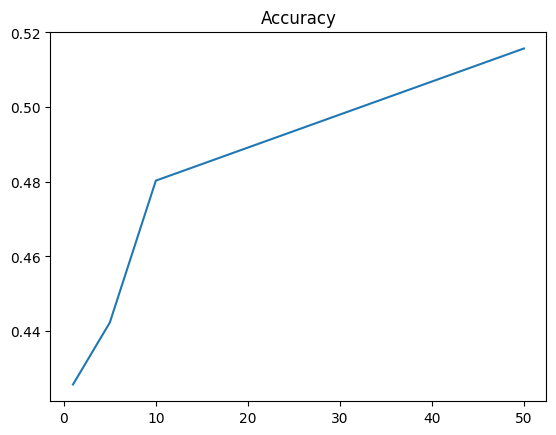

In [32]:
import matplotlib.pyplot as plt

plt.plot([1,5,10,50],Acc)
plt.title("Accuracy")

Text(0.5, 1.0, 'F1 score')

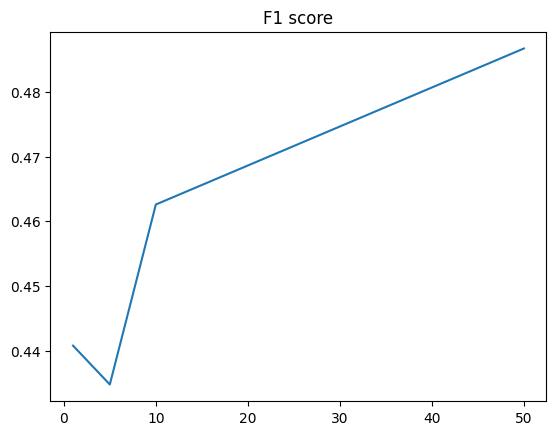

In [33]:
plt.plot([1,5,10,50],F1)
plt.title("F1 score")

نتایج تا حد خیلی خوبی جواب سوال یک را تایید می کند.

In [36]:
result = [a/b for a, b in zip(Time, Epochs)]
result


[14.511213016510009, 68.08727703775678, 136.55056643486023, 679.734776210785]

اما این ریزالت در حالت مدل برت معمولی به صورت زیر بود

In [ ]:
[76.03319475650787, 106.49334931373596, 209.76317278544107, 1029.6287331581116]

همانطور که می بینید زمان به ازای هر ایپاک در مدل با آداپتور بسیار کمتر شده اما از آن طرف اکیورسی ها تفاوت چندانی ندارند و حتی بعضا مدل با آداپتور بهتر عمل کرده است.

In [ ]:
BertTime=[760.3319475650787,532.4667465686798,629.2895183563232,3088.8861994743347]
BertF1=[0.3941,0.3810,0.4249,0.5134]
BertEpochs=[10,5,3,3]
BertAcc=[0.4673,0.4097,0.4443,0.5290]



AdapterTime=[145.1121301651001,476.6109392642975,682.7528321743011,3398.6738810539246]
AdapterF1=[0.4408,0.4348,0.4626,0.4867]
AdapterEpochs=[10,7,5,5]
AdapterAcc=[0.4257,0.4423,0.4803,0.5157]